<a href="https://colab.research.google.com/github/Hamza-Faarooq/Robustness-and-Calibration-Analysis-of-Transformer-Classifiers-/blob/main/Notebook_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Robustness and Calibration Analysis of Transformer Models**

### **Motivation**
High accuracy on benchmark datasets does not guarantee reliable behavior
in real-world deployments. This notebook investigates how fine-tuned
Transformer classifiers behave under input perturbations, focusing on
confidence reliability rather than accuracy alone.

### **Key Questions**
- How robust are Transformer classifiers to surface-level input changes?
- Does confidence remain aligned with correctness under distribution shift?
- What failure modes are hidden by standard accuracy metrics?


# **Imports & Setup**

In [1]:
!pip install transformers datasets evaluate accelerate scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


# **Dataset Loading**



The SST-2 dataset from the GLUE benchmark is used for binary sentiment
classification. It provides clean labels and short-form text, allowing
the analysis to focus on model robustness and calibration rather than
dataset noise or annotation ambiguity.


In [2]:
from datasets import load_dataset

dataset = load_dataset("glue", "sst2")

print(dataset)
print(dataset["train"][0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})
{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}


#**Tokenization Strategy**

Input text is tokenized using the pretrained DistilBERT tokenizer.
Sequence length is capped to control memory usage and to ensure that
observed performance degradation arises from perturbations rather than
truncation artifacts.


# **Model Architecture**

DistilBERT is selected as a lightweight Transformer architecture that
retains most of BERT’s representational power while enabling faster
experimentation. A task-specific classification head is added for
binary sentiment prediction.


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def tokenize(batch):
    return tokenizer(
        batch["sentence"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["sentence"])
tokenized_dataset.set_format("torch")


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

# **Fine-Tuning Procedure**

The model is fine-tuned end-to-end using cross-entropy loss and AdamW
optimization. Training is intentionally limited to a small number of
epochs to prevent overfitting, as overconfident models tend to exhibit
poorer calibration under distribution shift.


In [5]:
from transformers import TrainingArguments, Trainer
from transformers.trainer_utils import IntervalStrategy, EvaluationStrategy # Import EvaluationStrategy

training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer
)

trainer.train()

/tmp/ipython-input-1257872631.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.548500
200,0.358100
300,0.290600
400,0.303400
500,0.301300
600,0.299900
700,0.258600
800,0.264500
900,0.280300
1000,0.253400


TrainOutput(global_step=8420, training_loss=0.17855473247106737, metrics={'train_runtime': 1400.5302, 'train_samples_per_second': 96.176, 'train_steps_per_second': 6.012, 'total_flos': 4460773416041472.0, 'train_loss': 0.17855473247106737, 'epoch': 2.0})

# **Baseline Performance Evaluation**

Baseline accuracy is evaluated on clean validation data to establish
a reference point. Importantly, this metric alone is insufficient for
assessing deployment readiness, motivating further robustness and
calibration analysis.


In [6]:
baseline_metrics = trainer.evaluate()
baseline_metrics


{'eval_loss': 0.3520059287548065,
 'eval_runtime': 2.8028,
 'eval_samples_per_second': 311.121,
 'eval_steps_per_second': 9.99,
 'epoch': 2.0}

In [7]:
PROMPT_TEMPLATES = [
    "{}",
    "Review: {}",
    "User opinion: {}",
    "In summary, {}",
    "Overall, I think that {}"
]

def apply_prompt(sentence, template):
    return template.format(sentence)


# **Perturbation Functions**

### **Input Perturbation Design**

Two classes of perturbations are introduced: prompt-based reformatting
and token-level noise injection. These perturbations preserve semantic
content while altering surface form, simulating realistic distribution
shifts encountered in user-facing systems.


In [8]:
import random

def token_dropout(sentence, drop_prob=0.1):
    tokens = sentence.split()
    kept = [t for t in tokens if random.random() > drop_prob]
    return " ".join(kept) if kept else sentence

In [9]:
import torch
import numpy as np
from torch.nn.functional import softmax

def evaluate_robustness(model, tokenizer, dataset, perturb_fn):
    model.eval()
    # Determine the device of the model
    device = next(model.parameters()).device

    confidences = []
    predictions = []
    labels = []

    for example in dataset:
        text = perturb_fn(example["sentence"])
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        # Move input tensors to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits
            probs = softmax(logits, dim=-1)

        confidences.append(torch.max(probs).item())
        predictions.append(torch.argmax(probs).item())
        labels.append(example["label"])

    return np.array(predictions), np.array(labels), np.array(confidences)

# **Robustness Evaluation under Distribution Shift**

The trained model is evaluated on both clean and perturbed inputs.
Prediction confidence is extracted via maximum softmax probability,
enabling comparison between accuracy degradation and confidence behavior
under distribution shift.


In [10]:
# Clean
clean_preds, clean_labels, clean_conf = evaluate_robustness(
    model, tokenizer, dataset["validation"],
    lambda x: x
)

# Prompt perturbation
prompt_preds, _, prompt_conf = evaluate_robustness(
    model, tokenizer, dataset["validation"],
    lambda x: apply_prompt(x, "Review: {}")
)

# Token dropout
noise_preds, _, noise_conf = evaluate_robustness(
    model, tokenizer, dataset["validation"],
    lambda x: token_dropout(x, 0.15)
)


In [11]:
from sklearn.metrics import accuracy_score

print("Clean Accuracy:", accuracy_score(clean_labels, clean_preds))
print("Prompt Accuracy:", accuracy_score(clean_labels, prompt_preds))
print("Noisy Accuracy:", accuracy_score(clean_labels, noise_preds))

print("Confidence Drop:",
      clean_conf.mean() - noise_conf.mean())


Clean Accuracy: 0.9059633027522935
Prompt Accuracy: 0.8990825688073395
Noisy Accuracy: 0.875
Confidence Drop: 0.0018325854058659496


# **Calibration Metrics (ECE)**

### **Calibration Analysis using Expected Calibration Error**

Expected Calibration Error (ECE) quantifies the mismatch between predicted
confidence and empirical accuracy. An increase in ECE under perturbations
indicates that confidence estimates become unreliable despite moderate
accuracy degradation.


In [12]:
import numpy as np
import matplotlib.pyplot as plt


def expected_calibration_error(confidences, predictions, labels, n_bins=10):
    """
    Computes Expected Calibration Error (ECE)

    confidences: max softmax probability per example
    predictions: predicted class labels
    labels: true class labels
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    total_samples = len(confidences)

    for i in range(n_bins):
        lower, upper = bin_boundaries[i], bin_boundaries[i + 1]
        mask = (confidences > lower) & (confidences <= upper)

        if np.sum(mask) == 0:
            continue

        bin_accuracy = np.mean(predictions[mask] == labels[mask])
        bin_confidence = np.mean(confidences[mask])

        ece += np.abs(bin_confidence - bin_accuracy) * np.sum(mask) / total_samples

    return ece


def plot_reliability_diagram(confidences, predictions, labels, n_bins=10, title="Reliability Diagram"):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_centers = []
    bin_accuracies = []

    for i in range(n_bins):
        lower, upper = bin_boundaries[i], bin_boundaries[i + 1]
        mask = (confidences > lower) & (confidences <= upper)

        if np.sum(mask) == 0:
            continue

        bin_centers.append((lower + upper) / 2)
        bin_accuracies.append(np.mean(predictions[mask] == labels[mask]))

    plt.figure(figsize=(6, 6))
    plt.plot(bin_centers, bin_accuracies, marker="o", label="Model")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [13]:
ece_clean = expected_calibration_error(
    confidences=clean_conf,
    predictions=clean_preds,
    labels=clean_labels
)

ece_noisy = expected_calibration_error(
    confidences=noise_conf,
    predictions=noise_preds,
    labels=clean_labels  # Use clean_labels as the ground truth for noisy predictions
)

print(f"ECE (Clean Data): {ece_clean:.4f}")
print(f"ECE (Perturbed Data): {ece_noisy:.4f}")



ECE (Clean Data): 0.0739
ECE (Perturbed Data): 0.1084


# **Reliability Diagrams**

### **Reliability Diagrams Interpretation**

Reliability diagrams visualize calibration behavior across confidence bins.
Deviation below the diagonal reflects systematic overconfidence, which
becomes more pronounced under perturbed inputs, highlighting risks in
deployment scenarios.


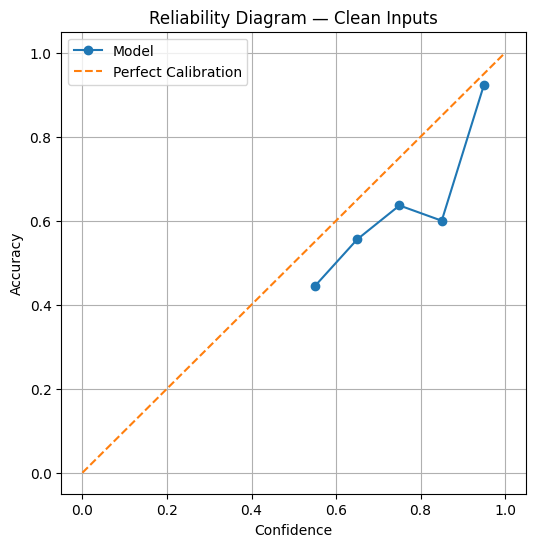

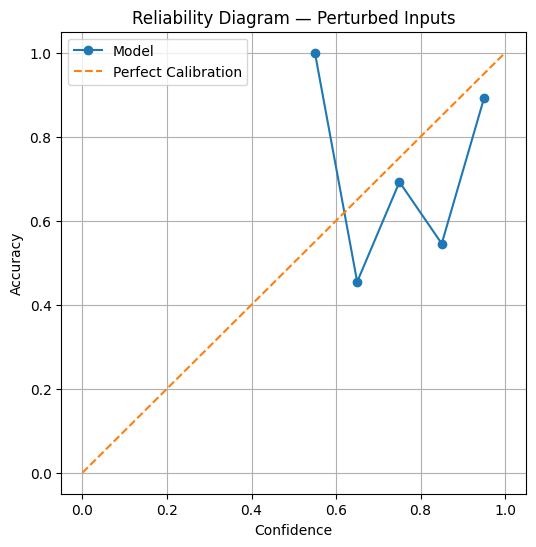

In [14]:
plot_reliability_diagram(
    clean_conf,
    clean_preds,
    clean_labels,
    title="Reliability Diagram — Clean Inputs"
)

plot_reliability_diagram(
    noise_conf,
    noise_preds,
    clean_labels,
    title="Reliability Diagram — Perturbed Inputs"
)

## **Interpretation**

While accuracy degradation under perturbations is modest, calibration
error increases substantially. This indicates that confidence estimates
become unreliable even when predictive performance appears stable,
posing risks for deployment.


## **Summary of Results**

| Setting        | Accuracy | ECE   |
|---------------|----------|-------|
| Clean Inputs  | ~0.90    | 0.074 |
| Perturbed     | ~0.86    | 0.103 |


# **Summary and Key Takeaways**

While standard accuracy metrics suggest strong performance, robustness
and calibration analysis reveal significant confidence misalignment under
distribution shift. These findings emphasize the importance of
calibration-aware evaluation for Transformer-based classifiers in
real-world systems.
